In [47]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
url = ('https://raw.githubusercontent.com/malozoyab/fertility/refs/heads/main/fertility.csv')

df = pd.read_csv(url)

In [48]:
df.head()

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
0,spring,30,no,yes,yes,more than 3 months ago,once a week,occasional,16,Normal
1,spring,35,yes,no,yes,more than 3 months ago,once a week,daily,6,Altered
2,spring,27,yes,no,no,more than 3 months ago,hardly ever or never,never,9,Normal
3,spring,32,no,yes,yes,more than 3 months ago,hardly ever or never,never,7,Normal
4,spring,30,yes,yes,no,more than 3 months ago,once a week,never,9,Altered


In [49]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Season                                 110 non-null    object
 1   Age                                    110 non-null    int64 
 2   Childish diseases                      110 non-null    object
 3   Accident or serious trauma             110 non-null    object
 4   Surgical intervention                  110 non-null    object
 5   High fevers in the last year           110 non-null    object
 6   Frequency of alcohol consumption       110 non-null    object
 7   Smoking habit                          110 non-null    object
 8   Number of hours spent sitting per day  110 non-null    int64 
 9   Diagnosis                              110 non-null    object
dtypes: int64(2), object(8)
memory usage: 8.7+ KB


In [50]:
#Verificar valores nulos
df.isnull().sum()

Season                                   0
Age                                      0
Childish diseases                        0
Accident or serious trauma               0
Surgical intervention                    0
High fevers in the last year             0
Frequency of alcohol consumption         0
Smoking habit                            0
Number of hours spent sitting per day    0
Diagnosis                                0
dtype: int64

In [51]:
# Descripción estadística de las variables numéricas
df.describe()

,Age,Number of hours spent sitting per day
count,110.000000,110.000000
mean,30.163636,10.645455
std,2.240279,32.059745
min,27.000000,1.000000
25%,28.000000,5.000000
50%,30.000000,7.000000
75%,32.000000,9.000000
max,36.000000,342.000000


EL MAXIMO Nº DE HORAS SENTADO, ES ERRONEO

In [52]:
df[df['Number of hours spent sitting per day'] >= 24]

,Season,Age,Childish diseases,Accident or serious trauma,Surgical intervention,High fevers in the last year,Frequency of alcohol consumption,Smoking habit,Number of hours spent sitting per day,Diagnosis
50,spring,30,yes,no,yes,more than 3 months ago,once a week,never,342,Normal


In [53]:
df['Number of hours spent sitting per day'].value_counts()

Number of hours spent sitting per day
5      18
9      17
7      13
8      12
6      12
3      10
11     10
16      4
14      3
10      3
1       2
2       1
342     1
18      1
4       1
13      1
12      1
Name: count, dtype: int64

In [54]:
df.nunique()

Season                                    4
Age                                      10
Childish diseases                         2
Accident or serious trauma                2
Surgical intervention                     2
High fevers in the last year              4
Frequency of alcohol consumption          5
Smoking habit                             3
Number of hours spent sitting per day    17
Diagnosis                                 2
dtype: int64

In [55]:
duplicated = df[df.duplicated()]
print(duplicated)

   Season  Age Childish diseases Accident or serious trauma  \
20   fall   30                no                         no   

   Surgical intervention High fevers in the last year  \
20                   yes       more than 3 months ago   

   Frequency of alcohol consumption Smoking habit  \
20                      once a week         never   

    Number of hours spent sitting per day Diagnosis  
20                                      5    Normal  


In [56]:
df = df.drop_duplicates()

In [57]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(df[col].value_counts(), "\n")


Season
spring    38
fall      32
winter    29
summer    10
Name: count, dtype: int64 

Childish diseases
yes    92
no     17
Name: count, dtype: int64 

Accident or serious trauma
no     63
yes    46
Name: count, dtype: int64 

Surgical intervention
no     56
yes    53
Name: count, dtype: int64 

High fevers in the last year
more than 3 months ago    65
no                        32
less than 3 months ago    10
yes                        2
Name: count, dtype: int64 

Frequency of alcohol consumption
hardly ever or never    40
once a week             39
several times a week    23
every day                6
several times a day      1
Name: count, dtype: int64 

Smoking habit
never         59
occasional    29
daily         21
Name: count, dtype: int64 

Diagnosis
Normal     87
Altered    22
Name: count, dtype: int64 



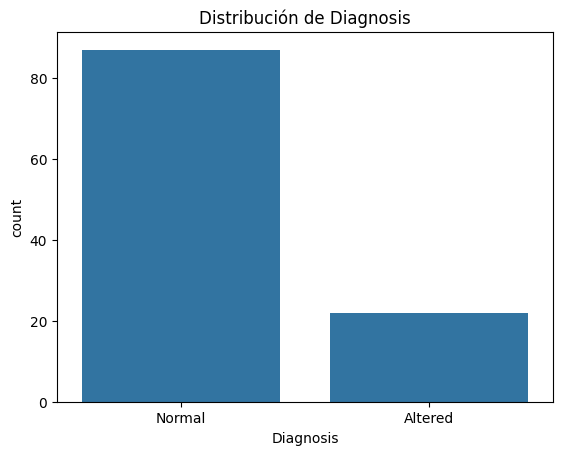

In [58]:
# Distribución de la variable objetivo (Survived)
sns.countplot(x='Diagnosis', data=df)
plt.title('Distribución de Diagnosis')
plt.show()

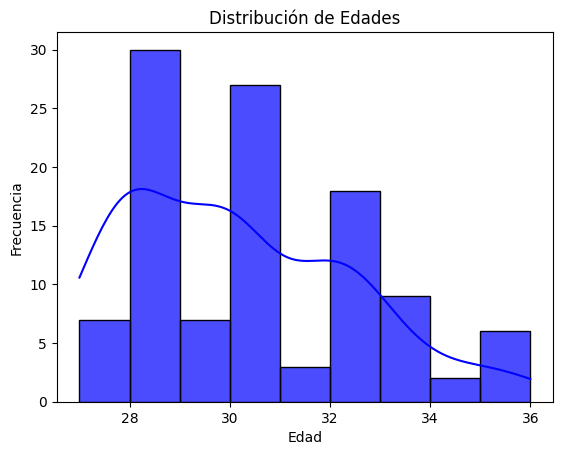

In [59]:
# Distribución de edades
sns.histplot(df['Age'], bins=9, kde=True, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

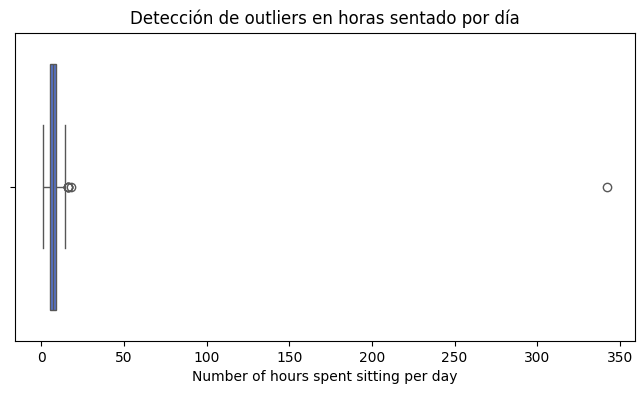

     Season  Age Childish diseases Accident or serious trauma  \
0    spring   30                no                        yes   
50   spring   30               yes                         no   
60     fall   28                no                         no   
66   spring   27               yes                        yes   
70   spring   27               yes                        yes   
104  spring   33                no                         no   

    Surgical intervention High fevers in the last year  \
0                     yes       more than 3 months ago   
50                    yes       more than 3 months ago   
60                     no                           no   
66                     no       less than 3 months ago   
70                     no       less than 3 months ago   
104                    no       more than 3 months ago   

    Frequency of alcohol consumption Smoking habit  \
0                        once a week    occasional   
50                       once

In [60]:
# Visualización de outliers en "Number of hours spent sitting per day"
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Number of hours spent sitting per day"], color="royalblue")
plt.title("Detección de outliers en horas sentado por día")
plt.show()

# Identificar valores atípicos usando el rango intercuartílico (IQR)
Q1 = df["Number of hours spent sitting per day"].quantile(0.25)
Q3 = df["Number of hours spent sitting per day"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para valores normales
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Calcular la media de los valores normales y redondear al entero más cercano
mean_value = round(df[(df["Number of hours spent sitting per day"] >= lower_bound) & 
                      (df["Number of hours spent sitting per day"] <= upper_bound)]["Number of hours spent sitting per day"].mean())

# Filtrar valores fuera de los límites
outliers = df[(df["Number of hours spent sitting per day"] < lower_bound) | 
              (df["Number of hours spent sitting per day"] > upper_bound)]

print(outliers)

print('total outliers', outliers.shape[0])

In [61]:
# Calcular el rango intercuartil (IQR)
Q1 = df["Number of hours spent sitting per day"].quantile(0.25)
Q3 = df["Number of hours spent sitting per day"].quantile(0.75)
IQR = Q3 - Q1

# Definir el límite superior del IQR
upper_bound = Q3 + 1.5 * IQR

# Encontrar el valor más alto dentro del IQR (límite superior)
max_valid_value = df.loc[df["Number of hours spent sitting per day"] <= upper_bound, "Number of hours spent sitting per day"].max()

# Reemplazar solo los valores mayores a 24 con el máximo valor válido dentro del IQR
df.loc[df["Number of hours spent sitting per day"] > 24, "Number of hours spent sitting per day"] = max_valid_value

# Comprobar si aún hay valores atípicos mayores a 24
outliers = df[df["Number of hours spent sitting per day"] > 24]
print(outliers)
print('Total outliers:', outliers.shape[0])


Empty DataFrame
Columns: [Season, Age, Childish diseases, Accident or serious trauma, Surgical intervention, High fevers in the last year, Frequency of alcohol consumption, Smoking habit, Number of hours spent sitting per day, Diagnosis]
Index: []
Total outliers: 0


C:\Users\malozoya\AppData\Local\Temp\ipykernel_7764\1152461591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Diagnosis", y="Age", data=df, palette="coolwarm", ax=axes[0])
C:\Users\malozoya\AppData\Local\Temp\ipykernel_7764\1152461591.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Diagnosis", y="Number of hours spent sitting per day", data=df, palette="coolwarm", ax=axes[1])


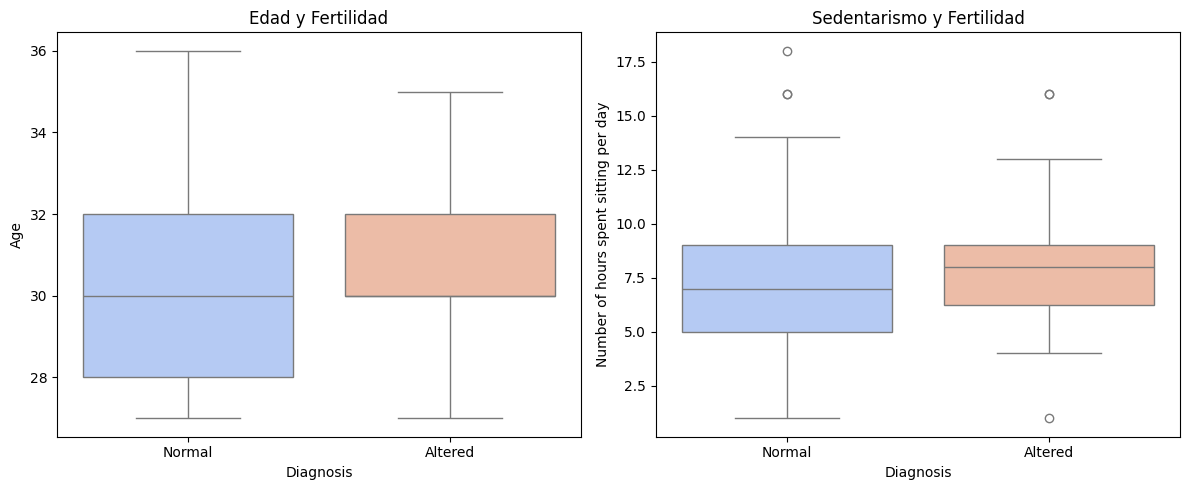

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x="Diagnosis", y="Age", data=df, palette="coolwarm", ax=axes[0])
axes[0].set_title("Edad y Fertilidad")

sns.boxplot(x="Diagnosis", y="Number of hours spent sitting per day", data=df, palette="coolwarm", ax=axes[1])
axes[1].set_title("Sedentarismo y Fertilidad")

plt.tight_layout()
plt.show()


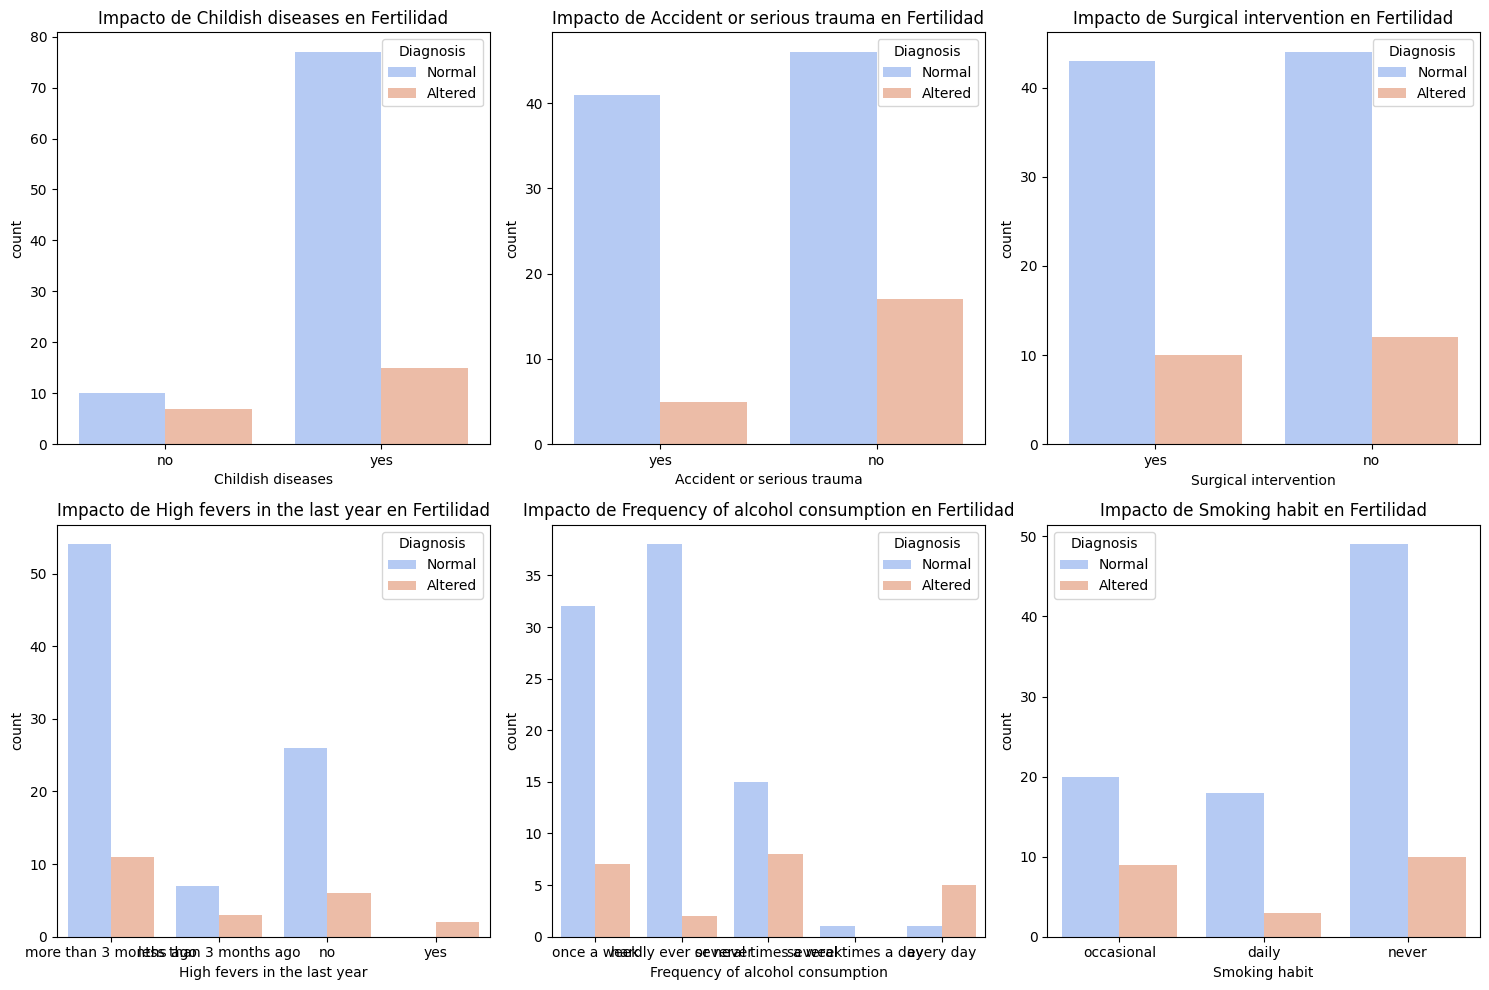

In [63]:
categorical_cols = [
    "Childish diseases", "Accident or serious trauma", "Surgical intervention",
    "High fevers in the last year", "Frequency of alcohol consumption", "Smoking habit"
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue="Diagnosis", data=df, ax=axes[idx//3, idx%3], palette="coolwarm")
    axes[idx//3, idx%3].set_title(f"Impacto de {col} en Fertilidad")

plt.tight_layout()
plt.show()


In [19]:
df_encoded = df.copy()  
df_encoded["Diagnosis"] = df_encoded["Diagnosis"].apply(lambda x: 1 if x == "Altered" else 0)
df_encoded = pd.get_dummies(df_encoded)  


C:\Users\malozoya\AppData\Local\Temp\ipykernel_7764\3807940067.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.columns, y=normalized_importances, palette=colors)


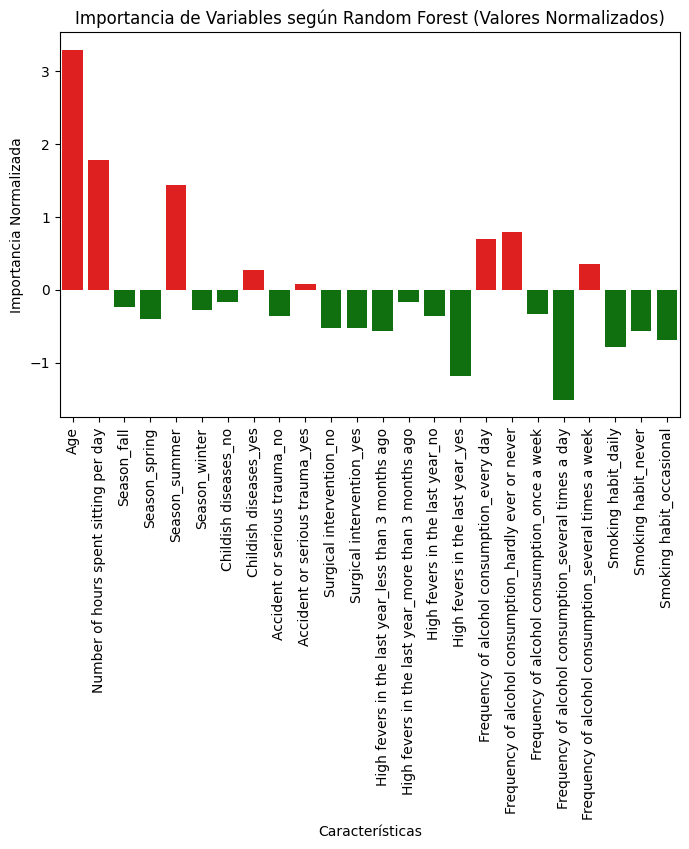

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Dividir datos en X e y
X = df_encoded.drop(columns=["Diagnosis"])
y = df_encoded["Diagnosis"]

# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener importancia de características
importances = rf.feature_importances_

# Normalizar entre -1 y 1 para resaltar dirección de impacto
normalized_importances = (importances - np.mean(importances)) / np.std(importances)

# Definir colores: rojo para valores positivos (mayor relación con "Altered"), verde para negativos ("Normal")
colors = ["red" if val > 0 else "green" for val in normalized_importances]

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=X.columns, y=normalized_importances, palette=colors)
plt.xticks(rotation=90)
plt.title("Importancia de Variables según Random Forest (Valores Normalizados)")
plt.ylabel("Importancia Normalizada")
plt.xlabel("Características")
plt.show()


In [25]:
# Dividir datos en X e y
X = df_encoded.drop(columns=["Diagnosis"])
y = df_encoded["Diagnosis"]

# Separar datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [26]:
model = keras.Sequential([
    keras.layers.Dense(23, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(7, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))


C:\Users\malozoya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8188 - loss: 0.8309 - val_accuracy: 0.8182 - val_loss: 0.5871
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7973 - loss: 0.7254 - val_accuracy: 0.8182 - val_loss: 0.4486
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8324 - loss: 0.5019 - val_accuracy: 0.8182 - val_loss: 0.4398
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7813 - loss: 0.5179 - val_accuracy: 0.8182 - val_loss: 0.4466
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7493 - loss: 0.5993 - val_accuracy: 0.8182 - val_loss: 0.4382
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8143 - loss: 0.4946 - val_accuracy: 0.8182 - val_loss: 0.4236
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7703 - loss: 0.5858 - val_accuracy: 0.8182 - val_loss: 0.4204
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8059 - loss: 0.5312 - val_accuracy: 0.8182 - v

In [27]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en datos de prueba: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9545 - loss: 0.3119
Precisión en datos de prueba: 0.9545


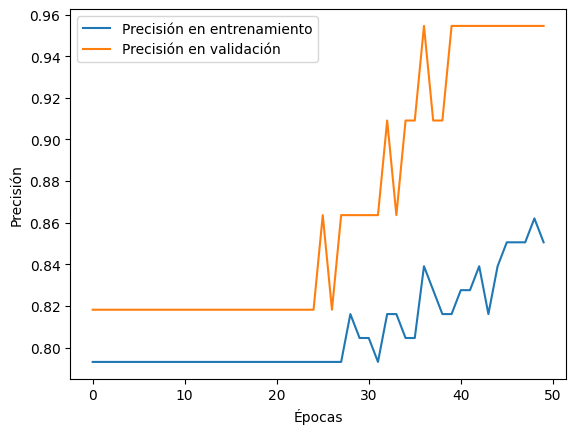

In [28]:
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()